In [1]:
pip install tensorflow-addons

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

# グラフのスタイルとサイズ
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 6]



In [3]:
 # 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1
!pip install pystan~=2.14
!pip install plotly


# matplotlib日本語化対応
import japanize_matplotlib
plt.rcParams['font.family'] = 'IPAexGothic'

358
353     2020年6月
354     2020年7月
355     2020年8月
356     2020年9月
357    2020年10月
Name: 年月, dtype: object
[ 892392  755702 1064849  928704  911359]


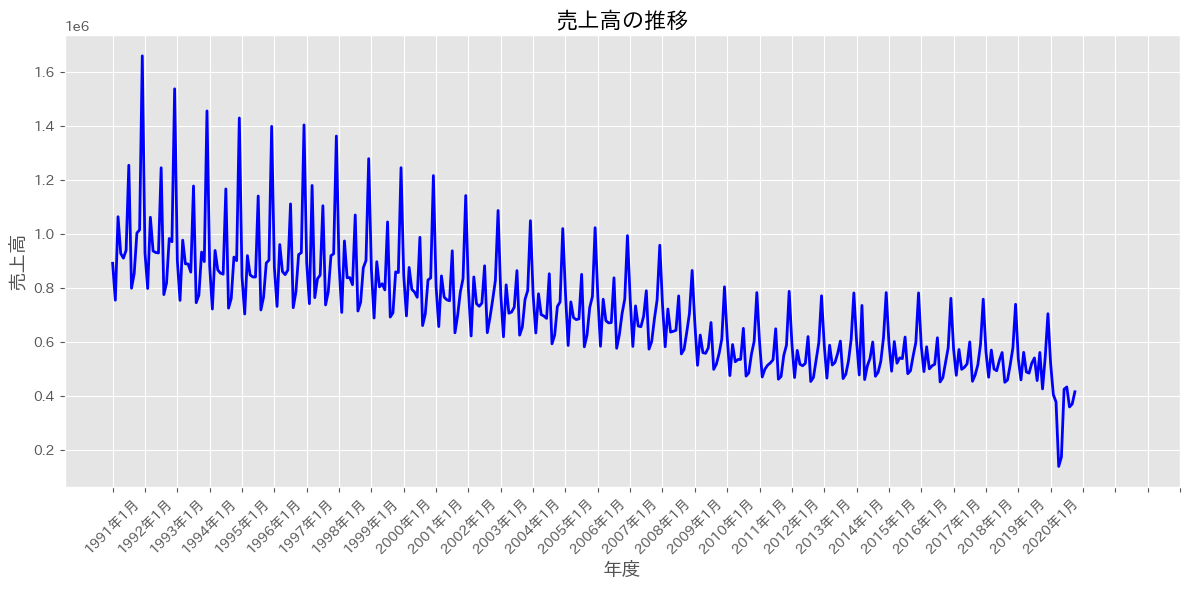

In [4]:
#ファイルの読込み
df = pd.read_csv('department_sales.csv', encoding='utf-8', skiprows=0)
month = df.iloc[:, 0]
print(len(month))
print(month[-5:])

data = df.iloc[:, 1]
data = data.values
print(data[:5])


# 折れ線グラフを描画
plt.figure(figsize=(12, 6))
plt.xticks(np.arange(0, 60, step=3))
plt.plot(month, data, color='b', linestyle='-', linewidth=2, markersize=8)
plt.xticks(np.arange(0, 400, step=12))
plt.title('売上高の推移', fontsize=16)
plt.xlabel('年度', fontsize=14)
plt.ylabel('売上高', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


# グラフを表示
plt.show()

In [5]:
# 型変換
data = pd.DataFrame(data)

# スケールの正規化
scaler = MinMaxScaler(feature_range=(0, 1))
df_scale = pd.DataFrame(scaler.fit_transform(data), index = data.index, columns=data.columns)


In [6]:
from sklearn.model_selection import train_test_split

# 学習データとテストデータの分別
train_data, test_data = train_test_split(df_scale, test_size=0.2, shuffle=False)

print("学習データ:")
print(train_data[:5])
print("\nテストデータ:")
print(test_data[:5])



学習データ:
          0
0  0.494831
1  0.404966
2  0.608211
3  0.518704
4  0.507301

テストデータ:
            0
286  0.313950
287  0.423408
288  0.302333
289  0.231974
290  0.304238


Epoch 1/100
274/274 [==============================] - 10s 12ms/step - loss: 0.0229
Epoch 2/100
274/274 [==============================] - 3s 13ms/step - loss: 0.0103
Epoch 3/100
274/274 [==============================] - 5s 17ms/step - loss: 0.0095
Epoch 4/100
274/274 [==============================] - 4s 15ms/step - loss: 0.0094
Epoch 5/100
274/274 [==============================] - 3s 13ms/step - loss: 0.0090
Epoch 6/100
274/274 [==============================] - 4s 15ms/step - loss: 0.0086
Epoch 7/100
274/274 [==============================] - 5s 17ms/step - loss: 0.0084
Epoch 8/100
274/274 [==============================] - 3s 13ms/step - loss: 0.0088
Epoch 9/100
274/274 [==============================] - 2s 7ms/step - loss: 0.0082
Epoch 10/100
274/274 [==============================] - 2s 7ms/step - loss: 0.0082
Epoch 11/100
274/274 [==============================] - 2s 8ms/step - loss: 0.0081
Epoch 12/100
274/274 [==============================] - 3s 10ms/step - loss: 0.0072
Epo

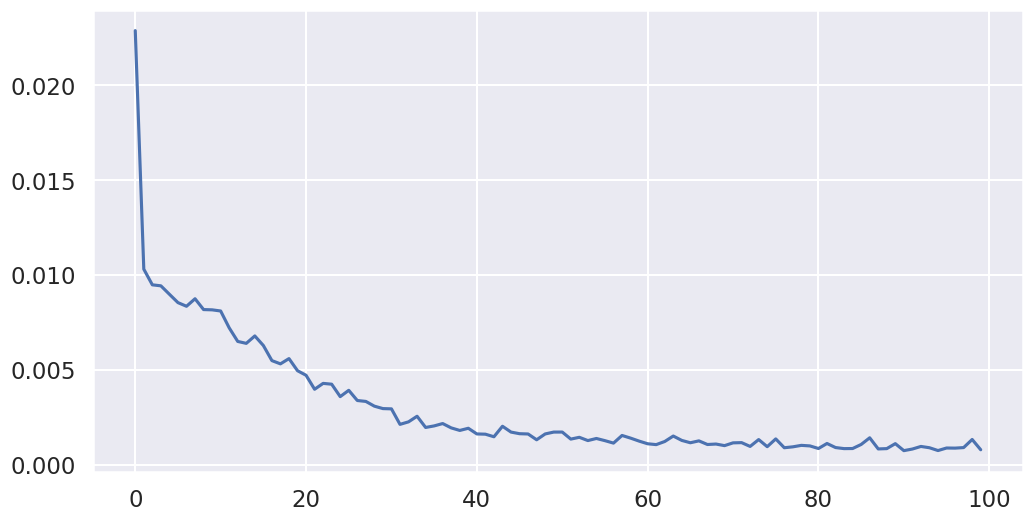

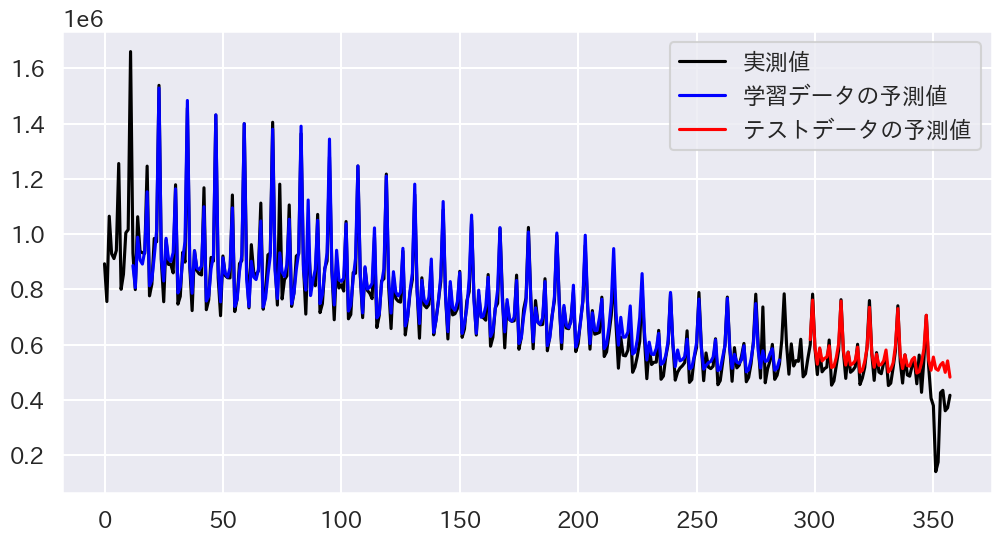

In [7]:
 #どれくらい過去まで見るか
look_back = 12


def create_input_data(data, look_back):
    raw_data = data.T.values.tolist()
    data_size = len(data) - look_back

    X = [[] for i in range(len(raw_data))]
    y = [[] for i in range(len(raw_data))]

    for i in range(data_size):
        for j in range(len(raw_data)):
            X[j].append(raw_data[j][i:i + look_back])
            y[j].append([raw_data[j][i + look_back]])

    X_tmp = X[-1]
    y_tmp = y[-1]

    for i in range(len(raw_data)-1):
        X_tmp = np.insert(X_tmp,np.arange(0, (look_back-1)*(i+1)+1, i+1),X[-i-2],axis=1)
        y_tmp = np.insert(y_tmp,np.arange(0, (i+1), i+1),y[-i-2],axis=1)

    X = np.array(X_tmp).reshape(data_size, look_back, len(raw_data))
    y = np.array(y_tmp).reshape(data_size, 1, len(raw_data))

    return y, X

y_train,X_train = create_input_data(
    data=train_data,
    look_back=look_back
)

y_test,X_test = create_input_data(
    data=test_data,
    look_back=look_back
)


#モデルの定義
model = Sequential()
x = model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(10))
model.add(Activation("relu"))
model.add(Dense(1)) # 出力次元数は1
optimizer = Adam(learning_rate=0.001)

#コンパイル
model.compile(loss="mean_squared_error", optimizer="adam")



history = model.fit(X_train, y_train, epochs=100, batch_size=1)

#精度の確認
print("精度の確認:")
model.evaluate(X_test,y_test,batch_size=1)

y_test = scaler.inverse_transform(test_data[:-12])
y_pred = scaler.inverse_transform(model.predict(X_test))

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"テストデータに対するMAPE: {mape}")

#学習曲線の確認
sns.set(context="talk")
fig = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])



import matplotlib.pyplot as plt
import matplotlib as mpl

# フォントの設定
mpl.rcParams['font.family'] = 'IPAexGothic'

# グラフのサイズを設定
plt.figure(figsize=(12, 6))

# 以降、プロットのコード
df_month = pd.DataFrame(scaler.inverse_transform(df_scale),
                       index=data.index,columns=data.columns)
plt.plot(df_month,color="black", label="実測値")

df_month_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=train_data.index[look_back:],columns=train_data.columns)
plt.plot(df_month_train_pred, color="blue", label="学習データの予測値")

df_month_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                  index=test_data.index[look_back:],columns=test_data.columns)
plt.plot(df_month_test_pred,color="red", label="テストデータの予測値")

plt.legend()



Epoch 1/100
274/274 [==============================] - 10s 14ms/step - loss: 0.0184
Epoch 2/100
274/274 [==============================] - 4s 14ms/step - loss: 0.0100
Epoch 3/100
274/274 [==============================] - 4s 16ms/step - loss: 0.0092
Epoch 4/100
274/274 [==============================] - 5s 17ms/step - loss: 0.0093
Epoch 5/100
274/274 [==============================] - 4s 14ms/step - loss: 0.0094
Epoch 6/100
274/274 [==============================] - 5s 18ms/step - loss: 0.0095
Epoch 7/100
274/274 [==============================] - 4s 14ms/step - loss: 0.0091
Epoch 8/100
274/274 [==============================] - 4s 14ms/step - loss: 0.0087
Epoch 9/100
274/274 [==============================] - 3s 10ms/step - loss: 0.0078
Epoch 10/100
274/274 [==============================] - 3s 10ms/step - loss: 0.0079
Epoch 11/100
274/274 [==============================] - 3s 9ms/step - loss: 0.0075
Epoch 12/100
274/274 [==============================] - 2s 7ms/step - loss: 0.0073
Ep

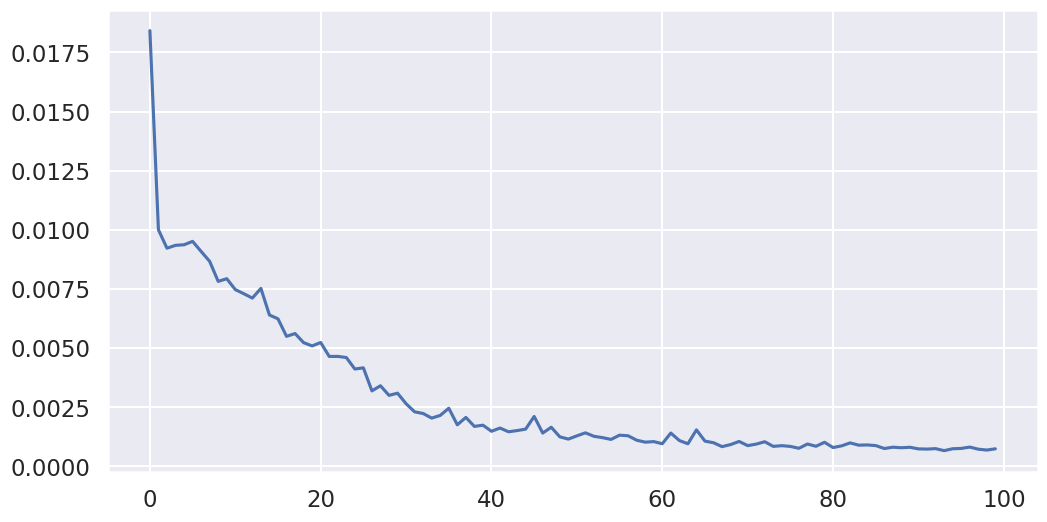

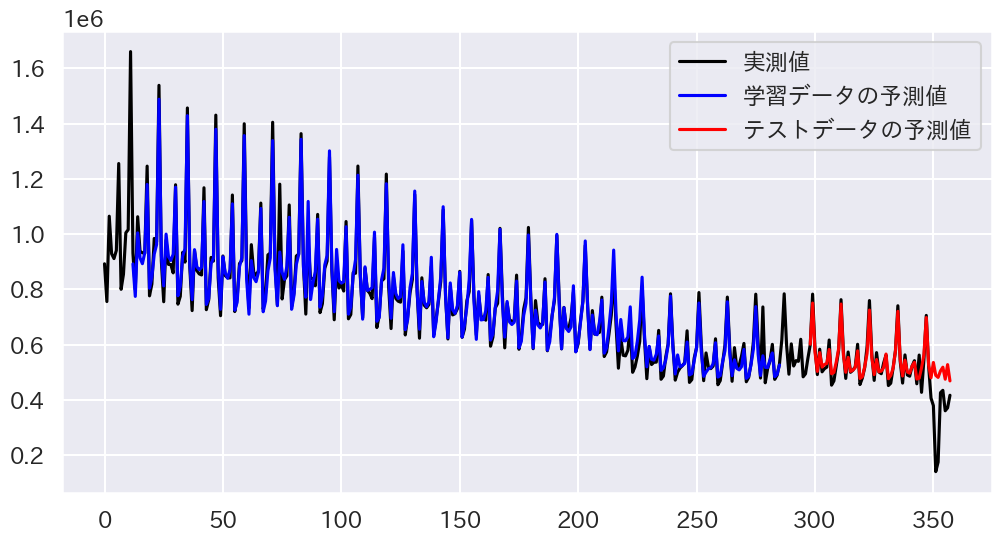

In [8]:
 #どれくらい過去まで見るか
look_back = 12


def create_input_data(data, look_back):
    raw_data = data.T.values.tolist()
    data_size = len(data) - look_back

    X = [[] for i in range(len(raw_data))]
    y = [[] for i in range(len(raw_data))]

    for i in range(data_size):
        for j in range(len(raw_data)):
            X[j].append(raw_data[j][i:i + look_back])
            y[j].append([raw_data[j][i + look_back]])

    X_tmp = X[-1]
    y_tmp = y[-1]

    for i in range(len(raw_data)-1):
        X_tmp = np.insert(X_tmp,np.arange(0, (look_back-1)*(i+1)+1, i+1),X[-i-2],axis=1)
        y_tmp = np.insert(y_tmp,np.arange(0, (i+1), i+1),y[-i-2],axis=1)

    X = np.array(X_tmp).reshape(data_size, look_back, len(raw_data))
    y = np.array(y_tmp).reshape(data_size, 1, len(raw_data))

    return y, X

y_train,X_train = create_input_data(
    data=train_data,
    look_back=look_back
)

y_test,X_test = create_input_data(
    data=test_data,
    look_back=look_back
)


#モデルの定義
model = Sequential()
x = model.add(LSTM(25, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(15))
model.add(Activation("relu"))
model.add(Dense(1)) # 出力次元数は1
optimizer = Adam(learning_rate=0.001)

#コンパイル
model.compile(loss="mean_squared_error", optimizer="adam")

history = model.fit(X_train, y_train, epochs=100, batch_size=1)

#精度の確認
print("精度の確認:")
model.evaluate(X_test,y_test,batch_size=1)

y_test = scaler.inverse_transform(test_data[:-12])
y_pred = scaler.inverse_transform(model.predict(X_test))

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"テストデータに対するMAPE: {mape}")

#学習曲線の確認
sns.set(context="talk")
fig = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])


import matplotlib.pyplot as plt
import matplotlib as mpl

# フォントの設定
mpl.rcParams['font.family'] = 'IPAexGothic'

# グラフのサイズを設定
plt.figure(figsize=(12, 6))

# 以降、プロットのコード
df_month = pd.DataFrame(scaler.inverse_transform(df_scale),
                       index=data.index,columns=data.columns)
plt.plot(df_month,color="black", label="実測値")

df_month_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=train_data.index[look_back:],columns=train_data.columns)
plt.plot(df_month_train_pred, color="blue", label="学習データの予測値")

df_month_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                  index=test_data.index[look_back:],columns=test_data.columns)
plt.plot(df_month_test_pred,color="red", label="テストデータの予測値")

plt.legend(loc='upper left')
plt.legend()



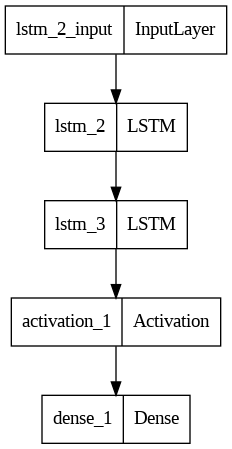

In [9]:
from keras.utils import plot_model

# モデルの図表を作成
plot_model(model)


Epoch 1/50
283/283 [==============================] - 5s 4ms/step - loss: 0.0376
Epoch 2/50
283/283 [==============================] - 1s 4ms/step - loss: 0.0143
Epoch 3/50
283/283 [==============================] - 1s 4ms/step - loss: 0.0137
Epoch 4/50
283/283 [==============================] - 1s 4ms/step - loss: 0.0139
Epoch 5/50
283/283 [==============================] - 1s 4ms/step - loss: 0.0141
Epoch 6/50
283/283 [==============================] - 1s 4ms/step - loss: 0.0136
Epoch 7/50
283/283 [==============================] - 2s 6ms/step - loss: 0.0138
Epoch 8/50
283/283 [==============================] - 2s 6ms/step - loss: 0.0132
Epoch 9/50
283/283 [==============================] - 1s 5ms/step - loss: 0.0133
Epoch 10/50
283/283 [==============================] - 1s 4ms/step - loss: 0.0134
Epoch 11/50
283/283 [==============================] - 1s 4ms/step - loss: 0.0132
Epoch 12/50
283/283 [==============================] - 1s 4ms/step - loss: 0.0130
Epoch 13/50
283/283 [====

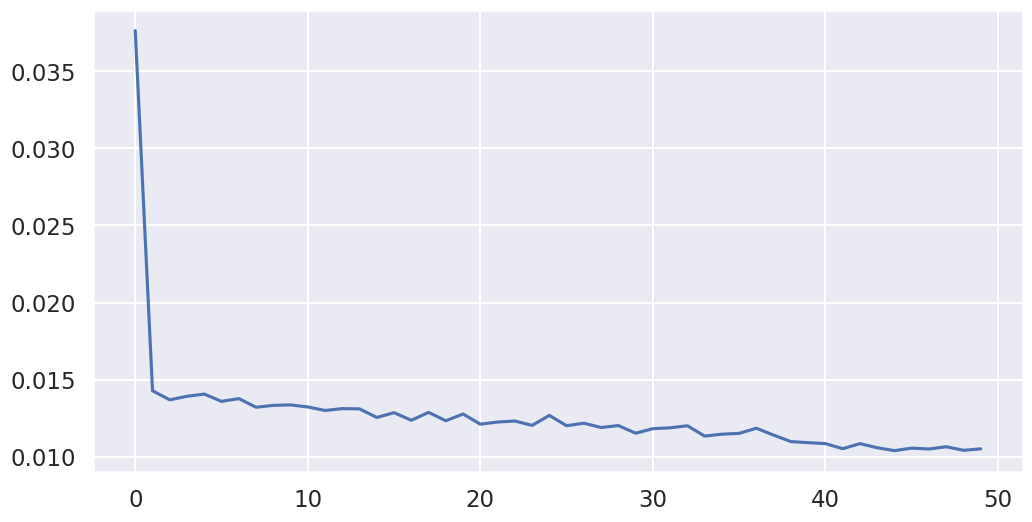

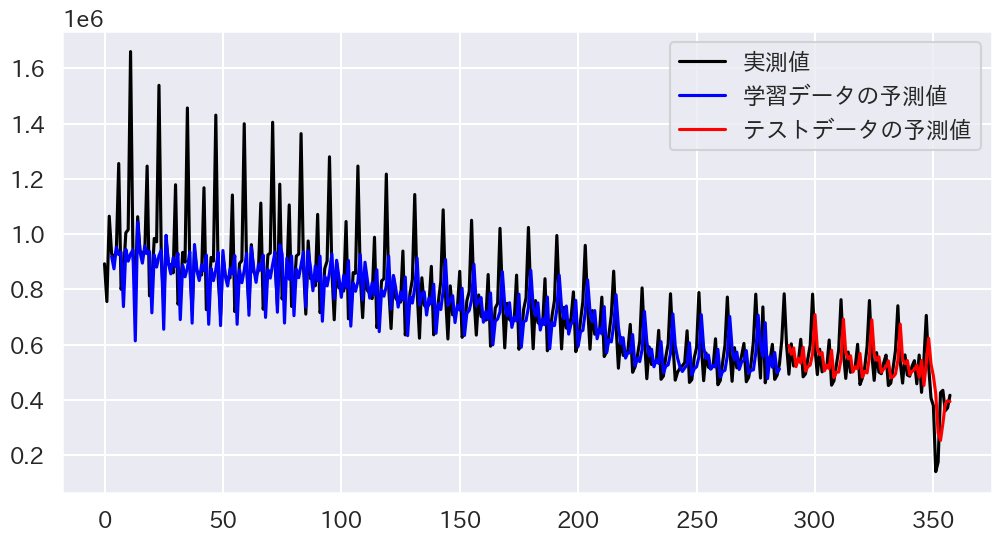

In [10]:
 #どれくらい過去まで見るか
look_back = 3


def create_input_data(data, look_back):
    raw_data = data.T.values.tolist()
    data_size = len(data) - look_back

    X = [[] for i in range(len(raw_data))]
    y = [[] for i in range(len(raw_data))]

    for i in range(data_size):
        for j in range(len(raw_data)):
            X[j].append(raw_data[j][i:i + look_back])
            y[j].append([raw_data[j][i + look_back]])

    X_tmp = X[-1]
    y_tmp = y[-1]

    for i in range(len(raw_data)-1):
        X_tmp = np.insert(X_tmp,np.arange(0, (look_back-1)*(i+1)+1, i+1),X[-i-2],axis=1)
        y_tmp = np.insert(y_tmp,np.arange(0, (i+1), i+1),y[-i-2],axis=1)

    X = np.array(X_tmp).reshape(data_size, look_back, len(raw_data))
    y = np.array(y_tmp).reshape(data_size, 1, len(raw_data))

    return y, X

y_train,X_train = create_input_data(
    data=train_data,
    look_back=look_back
)

y_test,X_test = create_input_data(
    data=test_data,
    look_back=look_back
)


#モデルの定義
model = Sequential()
x = model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(10))
model.add(Activation("relu"))
model.add(Dense(1)) # 出力次元数は1
optimizer = Adam(learning_rate=0.001)

#コンパイル
model.compile(loss="mean_squared_error", optimizer="adam")



history = model.fit(X_train, y_train, epochs=50, batch_size=1)

#精度の確認
print("精度の確認:")
model.evaluate(X_test,y_test,batch_size=1)

y_test = scaler.inverse_transform(test_data[:-3])
y_pred = scaler.inverse_transform(model.predict(X_test))

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"テストデータに対するMAPE: {mape}")

#学習曲線の確認
sns.set(context="talk")
fig = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])


import matplotlib.pyplot as plt
import matplotlib as mpl

# フォントの設定
mpl.rcParams['font.family'] = 'IPAexGothic'

# グラフのサイズを設定
plt.figure(figsize=(12, 6))

# 以降、プロットのコード
df_month = pd.DataFrame(scaler.inverse_transform(df_scale),
                       index=data.index,columns=data.columns)
plt.plot(df_month,color="black", label="実測値")

df_month_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=train_data.index[look_back:],columns=train_data.columns)
plt.plot(df_month_train_pred, color="blue", label="学習データの予測値")

df_month_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                  index=test_data.index[look_back:],columns=test_data.columns)
plt.plot(df_month_test_pred,color="red", label="テストデータの予測値")

plt.legend()


Epoch 1/50
283/283 [==============================] - 7s 6ms/step - loss: 0.0430
Epoch 2/50
283/283 [==============================] - 2s 8ms/step - loss: 0.0156
Epoch 3/50
283/283 [==============================] - 2s 8ms/step - loss: 0.0146
Epoch 4/50
283/283 [==============================] - 2s 6ms/step - loss: 0.0141
Epoch 5/50
283/283 [==============================] - 3s 9ms/step - loss: 0.0140
Epoch 6/50
283/283 [==============================] - 2s 9ms/step - loss: 0.0136
Epoch 7/50
283/283 [==============================] - 2s 8ms/step - loss: 0.0136
Epoch 8/50
283/283 [==============================] - 3s 9ms/step - loss: 0.0138
Epoch 9/50
283/283 [==============================] - 3s 10ms/step - loss: 0.0136
Epoch 10/50
283/283 [==============================] - 2s 8ms/step - loss: 0.0136
Epoch 11/50
283/283 [==============================] - 2s 8ms/step - loss: 0.0135
Epoch 12/50
283/283 [==============================] - 3s 9ms/step - loss: 0.0132
Epoch 13/50
283/283 [===

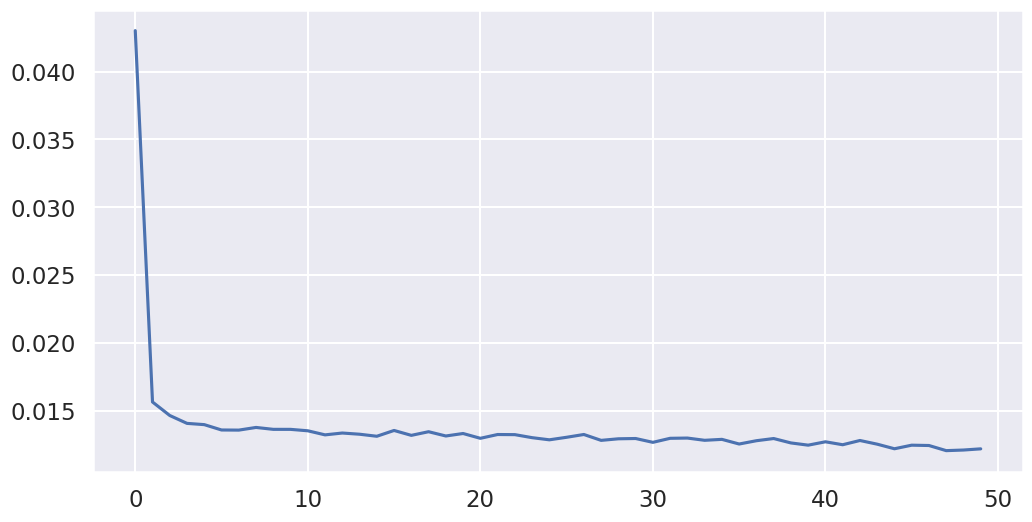

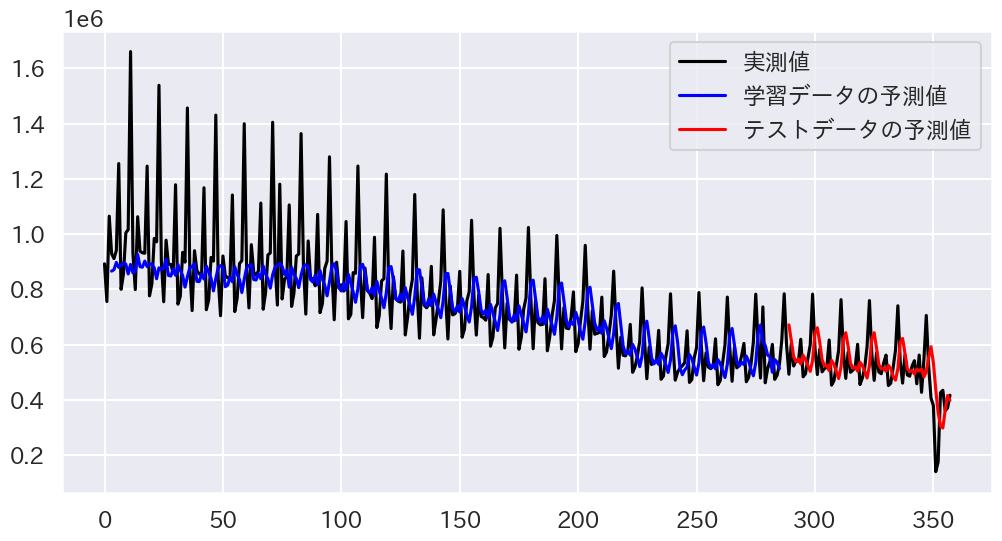

In [20]:
 #どれくらい過去まで見るか
look_back = 3


def create_input_data(data, look_back):
    raw_data = data.T.values.tolist()
    data_size = len(data) - look_back

    X = [[] for i in range(len(raw_data))]
    y = [[] for i in range(len(raw_data))]

    for i in range(data_size):
        for j in range(len(raw_data)):
            X[j].append(raw_data[j][i:i + look_back])
            y[j].append([raw_data[j][i + look_back]])

    X_tmp = X[-1]
    y_tmp = y[-1]

    for i in range(len(raw_data)-1):
        X_tmp = np.insert(X_tmp,np.arange(0, (look_back-1)*(i+1)+1, i+1),X[-i-2],axis=1)
        y_tmp = np.insert(y_tmp,np.arange(0, (i+1), i+1),y[-i-2],axis=1)

    X = np.array(X_tmp).reshape(data_size, look_back, len(raw_data))
    y = np.array(y_tmp).reshape(data_size, 1, len(raw_data))

    return y, X

y_train,X_train = create_input_data(
    data=train_data,
    look_back=look_back
)

y_test,X_test = create_input_data(
    data=test_data,
    look_back=look_back
)


#モデルの定義
model = Sequential()
x = model.add(LSTM(15, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(5))
model.add(Activation("relu"))
model.add(Dense(1)) #出力層はデータ数に合わせる

optimizer = Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer="adam")

history = model.fit(X_train, y_train, epochs=50, batch_size=1)

#精度の確認
print("精度の確認:")
model.evaluate(X_test,y_test,batch_size=1)

y_test = scaler.inverse_transform(test_data[:-3])
y_pred = scaler.inverse_transform(model.predict(X_test))

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"テストデータに対するMAPE: {mape}")

#学習曲線の確認
sns.set(context="talk")
fig = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])


import matplotlib.pyplot as plt
import matplotlib as mpl

# フォントの設定
mpl.rcParams['font.family'] = 'IPAexGothic'

# グラフのサイズを設定
plt.figure(figsize=(12, 6))

# 以降、プロットのコード
df_month = pd.DataFrame(scaler.inverse_transform(df_scale),
                       index=data.index,columns=data.columns)
plt.plot(df_month,color="black", label="実測値")

df_month_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=train_data.index[look_back:],columns=train_data.columns)
plt.plot(df_month_train_pred, color="blue", label="学習データの予測値")

df_month_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                  index=test_data.index[look_back:],columns=test_data.columns)
plt.plot(df_month_test_pred,color="red", label="テストデータの予測値")

plt.legend()


Epoch 1/50
283/283 [==============================] - 8s 6ms/step - loss: 0.0635
Epoch 2/50
283/283 [==============================] - 2s 6ms/step - loss: 0.0169
Epoch 3/50
283/283 [==============================] - 2s 6ms/step - loss: 0.0161
Epoch 4/50
283/283 [==============================] - 2s 6ms/step - loss: 0.0154
Epoch 5/50
283/283 [==============================] - 2s 8ms/step - loss: 0.0145
Epoch 6/50
283/283 [==============================] - 2s 7ms/step - loss: 0.0135
Epoch 7/50
283/283 [==============================] - 2s 6ms/step - loss: 0.0135
Epoch 8/50
283/283 [==============================] - 2s 6ms/step - loss: 0.0133
Epoch 9/50
283/283 [==============================] - 2s 6ms/step - loss: 0.0130
Epoch 10/50
283/283 [==============================] - 2s 6ms/step - loss: 0.0132
Epoch 11/50
283/283 [==============================] - 2s 5ms/step - loss: 0.0133
Epoch 12/50
283/283 [==============================] - 2s 6ms/step - loss: 0.0131
Epoch 13/50
283/283 [====

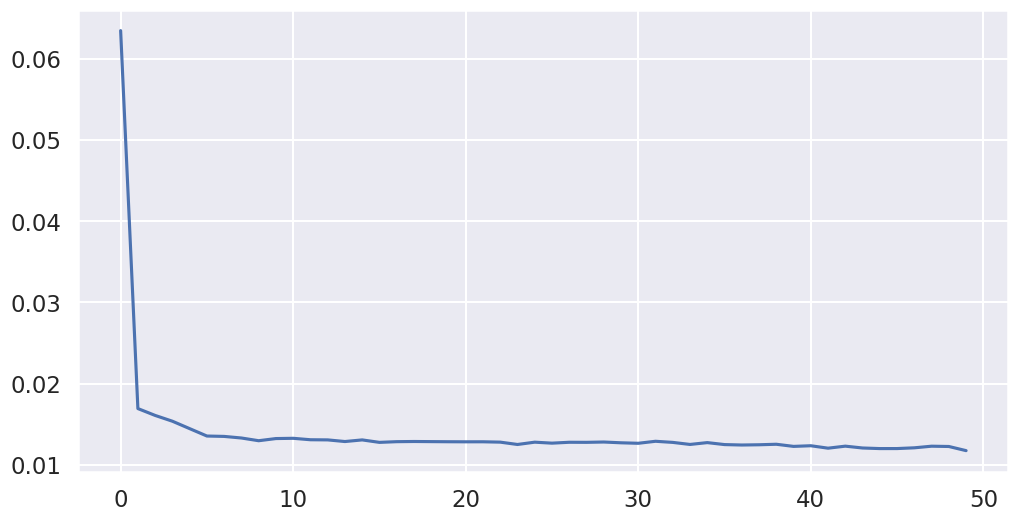

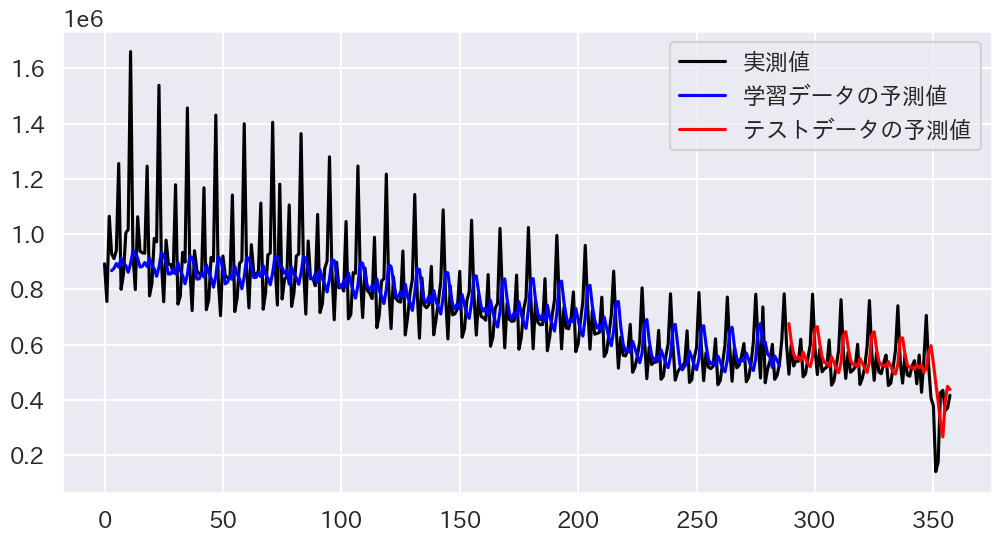

In [21]:
 #どれくらい過去まで見るか
look_back = 3


def create_input_data(data, look_back):
    raw_data = data.T.values.tolist()
    data_size = len(data) - look_back

    X = [[] for i in range(len(raw_data))]
    y = [[] for i in range(len(raw_data))]

    for i in range(data_size):
        for j in range(len(raw_data)):
            X[j].append(raw_data[j][i:i + look_back])
            y[j].append([raw_data[j][i + look_back]])

    X_tmp = X[-1]
    y_tmp = y[-1]

    for i in range(len(raw_data)-1):
        X_tmp = np.insert(X_tmp,np.arange(0, (look_back-1)*(i+1)+1, i+1),X[-i-2],axis=1)
        y_tmp = np.insert(y_tmp,np.arange(0, (i+1), i+1),y[-i-2],axis=1)

    X = np.array(X_tmp).reshape(data_size, look_back, len(raw_data))
    y = np.array(y_tmp).reshape(data_size, 1, len(raw_data))

    return y, X

y_train,X_train = create_input_data(
    data=train_data,
    look_back=look_back
)

y_test,X_test = create_input_data(
    data=test_data,
    look_back=look_back
)


#モデルの定義
model = Sequential()
x = model.add(LSTM(10, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(10))
model.add(Activation("relu"))
model.add(Dense(1)) #出力層はデータ数に合わせる

optimizer = Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer="adam")

history = model.fit(X_train, y_train, epochs=50, batch_size=1)

#精度の確認
print("精度の確認:")
model.evaluate(X_test,y_test,batch_size=1)

y_test = scaler.inverse_transform(test_data[:-3])
y_pred = scaler.inverse_transform(model.predict(X_test))

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"テストデータに対するMAPE: {mape}")

#学習曲線の確認
sns.set(context="talk")
fig = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])


import matplotlib.pyplot as plt
import matplotlib as mpl

# フォントの設定
mpl.rcParams['font.family'] = 'IPAexGothic'

# グラフのサイズを設定
plt.figure(figsize=(12, 6))

# 以降、プロットのコード
df_month = pd.DataFrame(scaler.inverse_transform(df_scale),
                       index=data.index,columns=data.columns)
plt.plot(df_month,color="black", label="実測値")

df_month_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=train_data.index[look_back:],columns=train_data.columns)
plt.plot(df_month_train_pred, color="blue", label="学習データの予測値")

df_month_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                  index=test_data.index[look_back:],columns=test_data.columns)
plt.plot(df_month_test_pred,color="red", label="テストデータの予測値")

plt.legend()
